Step 1: Import library


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, levene
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from semopy import Model, calc_stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')

Step 2: Preprocess Data

Step 2.1: Load data and delete some unused columns

In [11]:
# Load dataset
df = pd.read_csv("student.csv")

df = df.drop(['hour', 'day_of_month', 'day_of_week', 'month', 'pressure_at_sea', 'precip_dur_past10min', 'wind_dir', 
              'wind_speed', 'visib_mean_last10min', 'cloud_cover', 'visibility' ], axis=1)

Step 2.2: Convert data

In [12]:


# convert 'Datetime' to datetime format and sort
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df = df.dropna(subset=['Datetime']).sort_values('Datetime')

# create a copy for hourly data
df_hour = df.copy()

print(" Dataset loaded:", len(df_hour), "records (hourly data)")

 Dataset loaded: 26328 records (hourly data)


Step 2.3 Review data 

In [8]:
df_hour.head()

,Datetime,kWh,is_weekend,temp_dew,pressure,temp_dry,humidity
0,2018-11-01 00:00:00,0.247,0,5.900000,1011.083333,6.150000,98.333333
1,2018-11-01 01:00:00,0.131,0,6.250000,1010.883333,6.833333,96.166667
2,2018-11-01 02:00:00,0.132,0,5.950000,1010.600000,7.383333,90.833333
3,2018-11-01 03:00:00,0.076,0,5.616667,1010.533333,7.766667,86.166667
4,2018-11-01 04:00:00,0.061,0,5.516667,1010.100000,7.866667,85.000000


Step 3: Implement some models

Step 3.1: Descriptive statistics

=== (Descriptive Statistics) ===


,count,mean,std,min,Q1,median,Q3,max,CV(%),Skewness,Kurtosis
kWh,26328.0,0.202,0.208,0.001,0.076,0.122,0.252,2.438,102.892,3.057,12.747
temp_dry,26323.0,9.126,6.343,-16.417,4.583,8.550,13.767,29.517,69.506,0.178,-0.228
temp_dew,26323.0,6.153,5.851,-18.083,1.950,6.133,10.717,20.567,95.097,-0.162,-0.406
humidity,26323.0,83.411,14.915,19.333,75.500,88.000,95.000,100.000,17.881,-1.136,0.671


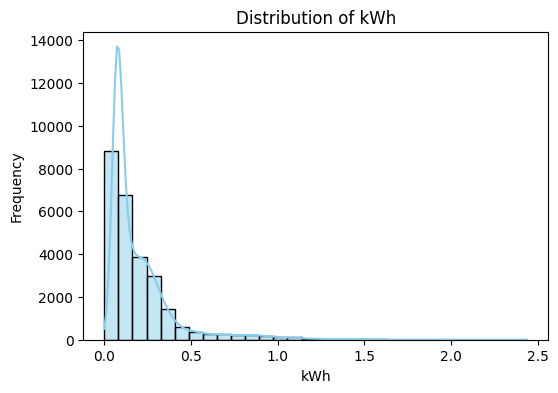

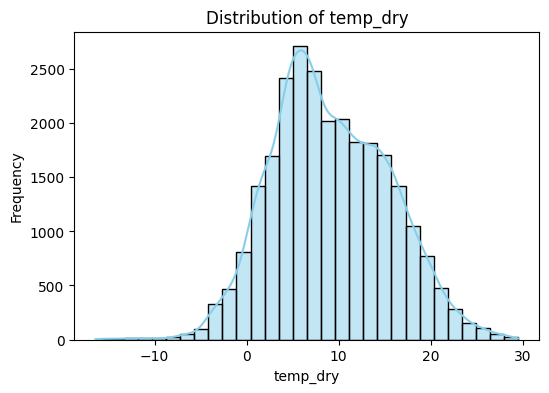

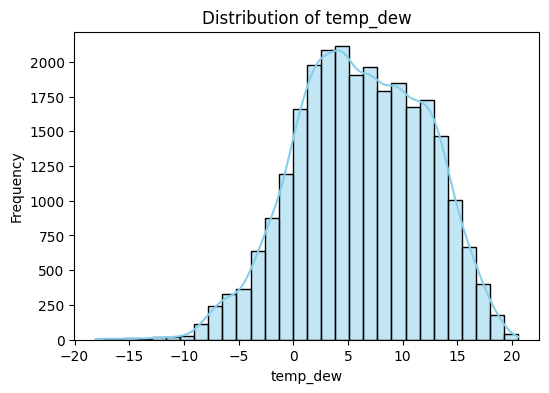

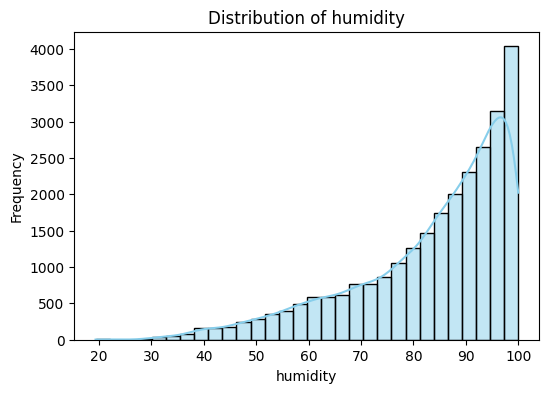

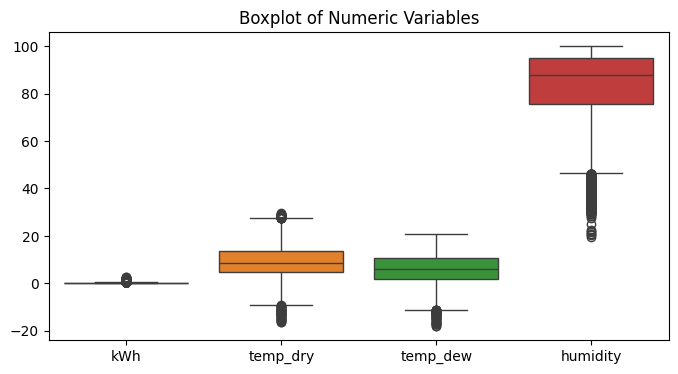

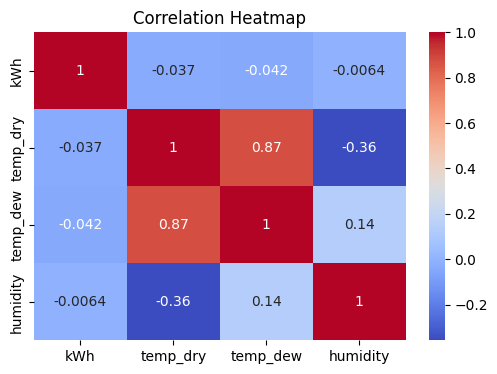

In [9]:
import numpy as np
from scipy.stats import skew, kurtosis

# Choose numeric columns
num_cols = ['kWh','temp_dry','temp_dew','humidity']
num_cols = [c for c in num_cols if c in df_hour.columns]

# Create an empty DataFrame to hold the statistics
stats = pd.DataFrame(index=num_cols, columns=[
    'count', 'mean', 'std', 'min', 'Q1', 'median', 'Q3', 'max',
    'CV(%)', 'Skewness', 'Kurtosis'
])

for col in num_cols:
    data = df_hour[col].dropna()
    stats.loc[col, 'count'] = data.count()
    stats.loc[col, 'mean'] = data.mean()
    stats.loc[col, 'std'] = data.std()
    stats.loc[col, 'min'] = data.min()
    stats.loc[col, 'Q1'] = data.quantile(0.25)
    stats.loc[col, 'median'] = data.median()
    stats.loc[col, 'Q3'] = data.quantile(0.75)
    stats.loc[col, 'max'] = data.max()
    stats.loc[col, 'CV(%)'] = (data.std() / data.mean()) * 100
    stats.loc[col, 'Skewness'] = skew(data)
    stats.loc[col, 'Kurtosis'] = kurtosis(data)

# Round the statistics for better readability
stats = stats.astype(float).round(3)

# Show the descriptive statistics table
print("=== (Descriptive Statistics) ===")
display(stats)

# Data Visualization
# Histogram + KDE
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df_hour[col], bins=30, kde=True, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

# Boxplot
plt.figure(figsize=(8,4))
sns.boxplot(data=df_hour[num_cols])
plt.title("Boxplot of Numeric Variables")
plt.show()

# Correlation heatmap
plt.figure(figsize=(6,4))
sns.heatmap(df_hour[num_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()